In [1]:
import pandas as pd
import matplotlib
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv("./data/Train.csv", sep=";")

In [3]:
dataset['opinion'].str.replace('"', '').str.lower().str.replace('&#039;ve', ' have').str.replace('&#039;s', 'is')

dataset['opinion'] = dataset['opinion'].str.lower()
dataset['opinion'] = dataset['opinion'].str.replace('"', '')
dataset['opinion'] = dataset['opinion'].str.replace(',', '')
dataset['opinion'] = dataset['opinion'].str.replace('.', '')
dataset['opinion'] = dataset['opinion'].str.replace('!', '')
dataset['opinion'] = dataset['opinion'].str.replace(':', '')
dataset['opinion'] = dataset['opinion'].str.replace('&#039;ve', ' have')
dataset['opinion'] = dataset['opinion'].str.replace('&#039;s', ' is')
dataset['opinion'] = dataset['opinion'].str.replace('&#039;t', ' not')
dataset['opinion'] = dataset['opinion'].str.replace('&#039;m', ' am')
dataset['opinion'] = dataset['opinion'].str.replace('&#039;ll', ' will')

dataset = dataset.drop_duplicates('opinion').reset_index()

AttributeError: 'DataFrame' object has no attribute 'ignore_index'

In [7]:
train_df, val_df = train_test_split(dataset, test_size=0.1, random_state=2137)

X_train = train_df.opinion.values
X_val = val_df.opinion.values

# LSTM

In [8]:
from gensim.models import KeyedVectors
import numpy as np

In [9]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin.gz' 
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [10]:
embed_size = 300 # how big is each word vector
max_features = 25000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 75 # max number of words in a question to use

In [12]:
X_train = train_df.opinion.values
X_val = val_df.opinion.values

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = max_features)

In [14]:
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [16]:
y_train = train_df['rate'].values
y_val = val_df['rate'].values

print(y_train)

[ 8  9  8 ...  6  3 10]


In [17]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPool1D, Bidirectional, GRU, Embedding, Input, LSTM, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K

In [66]:
embedding_matrix = np.zeros((max_features, embed_size))
for word, i in tokenizer.word_index.items():
    try:
        embedding_matrix[i, :] = word2vec.get_vector(word)
    except:
        pass
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
# x = GlobalMaxPool1D()(x)
x = Dense(32, activation="tanh", kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(1, kernel_regularizer=regularizers.l2(0.1))(x)
model = Model(inputs=inp, outputs=x)


adam = tf.keras.optimizers.Adam(lr=1e-3)


model.compile(loss='mse',
              optimizer=adam,
              metrics=['mse'])
print(model.summary())

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 75)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 75, 300)           7500000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 75, 256)           439296    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33  

In [67]:
model.fit(X_train, y_train, epochs = 10, batch_size=64, validation_data=(X_val, y_val))

Train on 96733 samples, validate on 10749 samples
Epoch 1/10
96733/96733 [==============================] - 30s 309us/sample - loss: 9.6478 - mse: 7.9301 - val_loss: 10.3397 - val_mse: 9.6821
Epoch 2/10
96733/96733 [==============================] - 28s 290us/sample - loss: 5.7041 - mse: 5.0980 - val_loss: 5.8811 - val_mse: 5.2898
Epoch 3/10
96733/96733 [==============================] - 29s 295us/sample - loss: 5.1595 - mse: 4.5820 - val_loss: 5.4515 - val_mse: 4.8904
Epoch 4/10
96733/96733 [==============================] - 28s 294us/sample - loss: 4.7733 - mse: 4.2120 - val_loss: 5.2778 - val_mse: 4.7166
Epoch 5/10
96733/96733 [==============================] - 29s 295us/sample - loss: 4.4063 - mse: 3.8462 - val_loss: 6.4786 - val_mse: 5.9422
Epoch 6/10
96733/96733 [==============================] - 29s 298us/sample - loss: 4.0935 - mse: 3.5329 - val_loss: 5.2867 - val_mse: 4.7390
Epoch 7/10
96733/96733 [==============================] - 29s 299us/sample - loss: 3.7883 - mse: 3.2227

In [68]:
y_hat = model.predict(X_val)

In [69]:
y_hat

array([[9.186721 ],
       [8.400174 ],
       [7.2377934],
       ...,
       [8.407116 ],
       [8.934783 ],
       [9.052675 ]], dtype=float32)

In [70]:
y_hat_cat = np.clip(np.rint(y_hat.flatten()), 1, 10).astype(int)

In [71]:
y_hat_cat

array([9, 8, 7, ..., 8, 9, 9])

In [72]:
from sklearn.metrics import mean_squared_error 

In [73]:
mean_squared_error(y_hat_cat, y_val)

4.883617080658666

In [74]:
from matplotlib import pyplot as plt

(array([ 299.,  815.,  674.,  524.,  492.,  596.,  798., 1522., 4691.,
         338.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 10 Patch objects>)

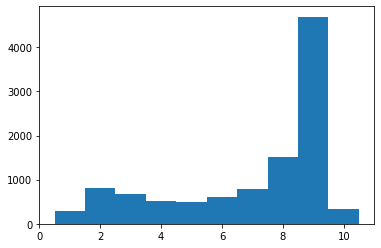

In [84]:
plt.hist(y_hat_cat, bins=10, range=[0.5, 10.5])

(array([1452.,  473.,  428.,  329.,  519.,  421.,  618., 1243., 1851.,
        3415.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 10 Patch objects>)

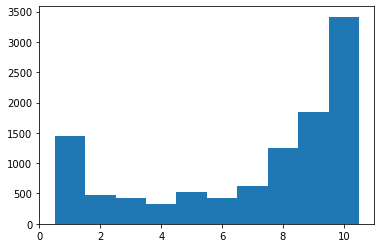

In [85]:
plt.hist(y_val, bins=10, range=[0.5, 10.5])

In [86]:
y_hat_train = model.predict(X_train)

In [93]:
from functools import partial
import scipy as sp
from sklearn import metrics
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']


In [94]:
optR = OptimizedRounder()
optR.fit(y_hat_train, y_train)
coefficients = optR.coefficients()
y_hat_train_cls = optR.predict(y_hat, coefficients)
y_hat_val_cls = optR.predict(y_hat_train, coefficients)


(array([27331.,     0.,  2107., 67295.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5],
       dtype=float32),
 <a list of 10 Patch objects>)

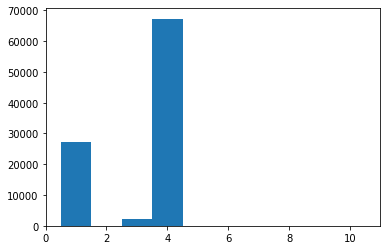

In [95]:
plt.hist(y_hat_val_cls, bins=10, range=[0.5, 10.5])